<center> <h1> Phase III </h1> </center>
<center> <h3> A pre-registration of analyses for the final report </h3> <center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.linear_model import LinearRegression

### Overview
My project is to create a model that could have historically won money betting on UFC fights using Las Vegas Betting Lines. The analyses I present are trying to find patterns in the data that might help me predict fight outcomes. 

<h5> Uploading Cleaned Data </h5> 
The uploaded file is the cleaned version of UFC data that was created in Phase II. It contains statistics from every UFC bout since 2010 and is cleaned of any empty or falsely entered entries. 

In [2]:
# Upload and view data
ufc_data = pd.read_csv('cleaned_ufc.csv')
print('# of Rows: {}'.format(ufc_data.shape[0]))
print('# of Columns: {}'.format(ufc_data.shape[1]))
ufc_data.head()

# of Rows: 1003
# of Columns: 107


,Unnamed: 0,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,Winner,title_bout,weight_class,...,R_td_attempted_bout,B_td_attempted_bout,R_td_pct_bout,B_td_pct_bout,R_sub_attempts_bout,B_sub_attempts_bout,R_pass_bout,B_pass_bout,R_rev_bout,B_rev_bout
0,0,Petr Yan,Jose Aldo,-215.0,175.0,46.511628,175.0,Red,True,Bantamweight,...,2.0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,Amanda Ribas,Paige VanZant,-770.0,500.0,12.987013,500.0,Red,False,Women's Flyweight,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,Volkan Oezdemir,Jiri Prochazka,-159.0,129.0,62.893082,129.0,Blue,False,Light Heavyweight,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Makwan Amirkhani,Danny Henry,-215.0,170.0,46.511628,170.0,Red,False,Featherweight,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,Martin Day,Davey Grant,-162.0,130.0,61.728395,130.0,Blue,False,Bantamweight,...,1.0,4.0,0.0,0.5,0.0,1.0,0.0,1.0,1.0,0.0


#### Data Cleaning For Regression Analyses
Each row in the data set contains the statistics for the red and blue fighter in each bout. I am going to separate the data into a red and blue dataset and then, recombine the datasets so only one fighter is contained per row. 

#### Data Changes 
1. Eliminate the columns that are not used in the models. 
2. Some of the statistics capture the differences in characteristics between the fighters. In order to preserve the relationship between difference statistics, I need to flip the sign for the blue fighters so that the difference statistics are consistent. 
3. I created a new column for difference between the average takedown landed per fifteen minutes for each fighter because I thought this statistic would be important for predicting fight outcomes. 
4. I replaced the winner column that denoted whether the red or blue column won with a dummy variable that equals 1 when the fighter wins and 0 otherwise. 

In [261]:
# Flipping signs and creating cew column
ufc_data['B_td_landed_dif'] = ufc_data['B_avg_TD_landed'] - ufc_data['R_avg_TD_landed']
ufc_data['R_td_landed_dif'] = ufc_data['R_avg_TD_landed'] - ufc_data['B_avg_TD_landed']
ufc_data['B_sig_str_dif'] = ufc_data['sig_str_dif']
ufc_data['R_sig_str_dif'] = -ufc_data['sig_str_dif']
ufc_data['B_reach_dif'] = ufc_data['reach_dif']
ufc_data['R_reach_dif'] = -ufc_data['reach_dif']
ufc_data['B_total_round_dif'] = ufc_data['total_round_dif']
ufc_data['R_total_round_dif'] = -ufc_data['total_round_dif']

In [262]:
# Split dataset into red and blue 
ufc_red = ufc_data[['R_fighter', 'R_odds', 'R_ev', 'Winner', 'weight_class', 'gender', 'R_td_landed_dif', 
                   'R_sig_str_dif', 'R_reach_dif', 'R_total_round_dif']]
ufc_blue = ufc_data[['B_fighter', 'B_odds', 'B_ev', 'Winner', 'weight_class', 'gender', 'B_td_landed_dif', 
                   'B_sig_str_dif', 'B_reach_dif', 'B_total_round_dif']]

In [263]:
# Create dummy variable for winning in each dataframe
ufc_red = ufc_red.replace('Red', 1)
ufc_red = ufc_red.replace('Blue', 0)
ufc_blue = ufc_blue.replace('Blue', 1)
ufc_blue = ufc_blue.replace('Red', 0)

In [264]:
# Rename red columns for the merge
ufc_red = ufc_red.rename(columns={'R_fighter': 'name', 'R_odds': 'odds', 'Winner' : 'winner' , 'R_ev' : 'ev', 
                                  'R_td_landed_dif' : 'td_landed_dif', 'R_sig_str_dif' : 'sig_str_dif', 
                                  'R_reach_dif' : 'reach_dif', 'R_total_round_dif' : 'total_round_dif'})
ufc_red.columns

Index(['name', 'odds', 'ev', 'winner', 'weight_class', 'gender',
       'td_landed_dif', 'sig_str_dif', 'reach_dif', 'total_round_dif'],
      dtype='object')

In [265]:
# Rename blue columns for the merge
ufc_blue = ufc_blue.rename(columns={'B_fighter': 'name', 'B_odds': 'odds', 'Winner' : 'winner', 'B_ev' : 'ev', 
                                    'B_td_landed_dif' : 'td_landed_dif', 'B_sig_str_dif' : 'sig_str_dif',
                                    'B_reach_dif' : 'reach_dif', 'B_total_round_dif' : 'total_round_dif'})
ufc_blue.columns

Index(['name', 'odds', 'ev', 'winner', 'weight_class', 'gender',
       'td_landed_dif', 'sig_str_dif', 'reach_dif', 'total_round_dif'],
      dtype='object')

In [266]:
# Concatenate the Datasets
data = [ufc_red, ufc_blue]
ufc = pd.concat(data)

In [267]:
# Test whether dataframe is correct size
ufc.shape

(2006, 10)

The dataframe is the exact size we would expect if were to split each row and reconcatenate. 

#### Linear Regression Using Betting Odds
The Las Vegas odds set the betting probabilities for each each fight and should be a helpful predictor for fight outcomes. 

In [268]:
# Reshaping columns that we can run through the linear regression
odds = ufc['odds'].values
odds = odds.reshape(-1,1)
winner = ufc['winner'].values
winner = winner.reshape(-1,1)

In [269]:
betting_model = LinearRegression()
betting_model.fit(odds, winner)
print('Regression coefficient for betting odds:', betting_model.coef_[0])
print('Correlation coefficient between betting odds and fight outcomes:', round(np.corrcoef(ufc['odds'], ufc['winner'])[0,1],4))

Regression coefficient for betting odds: [-0.00064332]
Correlation coefficient between betting odds and fight outcomes: -0.3772


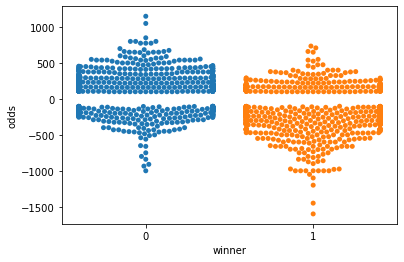

In [270]:
plt.figure(figsize=(6,4))
sns.swarmplot(
    x='winner',
    y='odds',
    data=ufc
)
plt.show()

#### Conclusion: Single Linear Regression with Betting Odds
The betting odds without any scaling do not seem to be great predictors of fight outcomes. There are positively correlate so maybe if I can scale the betting odds down or convert them into win probability they will be more helpful. 

#### Multiple Regression
In this model, we will use a few statistics that I think might be useful in predicting fight outcomes: difference in successful takedowns, difference in significant strikes landed, reach difference, and difference in total rounds fought.

In [271]:
# Linear regression using fight differences 
multi_model = LinearRegression()
multi_model.fit(ufc[['td_landed_dif', 'sig_str_dif', 'reach_dif', 'total_round_dif']], ufc['winner'])
print('Takedown Difference Regression Coefficient', multi_model.coef_[0])
print('Strike Difference Regression Coefficient', multi_model.coef_[1])
print('Reach Difference Regression Coefficient', multi_model.coef_[2])
print('Experience Difference Regression Coefficient', multi_model.coef_[3])

Takedown Difference Regression Coefficient 0.010097520352288867
Strike Difference Regression Coefficient 0.0015957434124107038
Reach Difference Regression Coefficient 0.004447024562230372
Experience Difference Regression Coefficient -0.001416340110051907


In [272]:
# Evaluation correlation coefficient between 
multi_pred = multi_model.predict(ufc[['td_landed_dif', 'sig_str_dif', 'reach_dif', 'total_round_dif']])
print('Multiple Regression Model Correlation Coefficient', round(np.corrcoef(multi_pred, ufc['winner'])[0,1],3))

Multiple Regression Model Correlation Coefficient 0.123


#### Conclusion
The multiple regession model was not that effective in predicting fight outcomes as evident by the low correlation coefficient. 

<h5> Questions for Reviewers </h5>

1. Any suggestions for how I could scale my data to get better predictive results. 
2. Should I subset my data by gender or weight class and focus my model for only a small subset.
3. Are you aware of any models that were not discussed in class that might be helpful. 